In [1]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
sns.set(color_codes=True)
%matplotlib inline

In [2]:
runs = MlflowClient(tracking_uri="file:/data/logs/kristian/mlruns").search_runs(
  experiment_ids="7",
  filter_string="tags.type = 'quantization'",
)

In [39]:
data = np.zeros((8, 9))

In [40]:
for run in runs:
    qta = run.data.metrics['q_motion_blur_2_test/acc']
    ap = int(run.data.params['quantization/activation_precision'])
    wp = int(run.data.params['quantization/weight_precision'])
    data[ap, wp] = qta



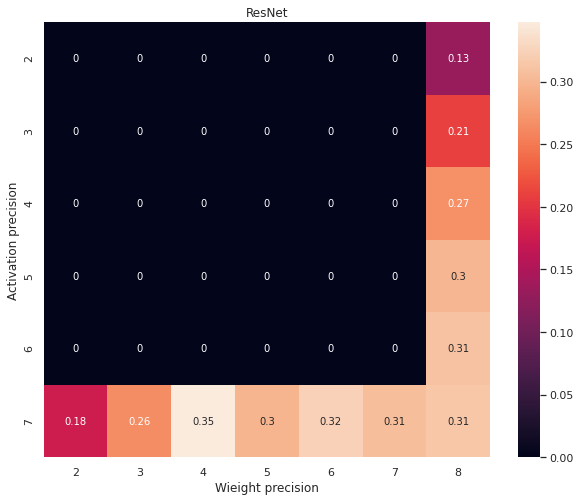

<Figure size 432x288 with 0 Axes>

In [41]:
fig, ax = plt.subplots(figsize=(10,8))
fig = sns.heatmap(data[2:,2:], annot=True, xticklabels=[2,3,4,5,6,7,8], yticklabels=[2,3,4,5,6,7])
plt.xlabel("Wieight precision")
plt.ylabel("Activation precision")
plt.title("ResNet")
plt.show(fig)
plt.savefig('/home/k.schwienbacher/quantization-robustness/data/resnet-heatmap-c.jpg')

In [3]:
experiments = [
    {'id': "14", 'train_id': "8", 'name': 'squeezenet' }, 
    {'id': "7", 'name': 'lenet' }, 
    {'id': "10", 'train_id': "3", 'name': 'resnet18' }, 
    {'id': "11", 'name': 'lenetplus' },
    #{'id': "17", 'name': 'lenet_cinic' },

]

In [4]:
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
runs = []


for exp in experiments:
  df_runs = mlflow.search_runs(
    experiment_ids=exp['id'],
    filter_string="tags.stage = 'eval'",
    output_format="pandas"
  )
  fp_runs = mlflow.search_runs(
    experiment_ids=exp["train_id"] if "train_id" in exp.keys() else exp['id'],
    filter_string="tags.stage = 'train'",
    output_format="pandas",
    max_results=1,
  )
  fp_runs["params.quantization/weight_precision"] = 'fp'
  fp_runs["metrics.q_test/acc"] = fp_runs["metrics.test/acc"]
  fp_runs = fp_runs.set_index("params.quantization/weight_precision")

  run = df_runs[df_runs["params.quantization/activation_precision"] == '7'].set_index("params.quantization/weight_precision")
  run = run.append(fp_runs.iloc[0])
  run.sort_index(inplace=True, ascending=False)

  run['name'] = exp['name']
  runs.append((exp['name'], run))


In [8]:
df = pd.DataFrame()
for name, run in runs:
    df[name] = run["metrics.q_contrast_2_test/acc"]

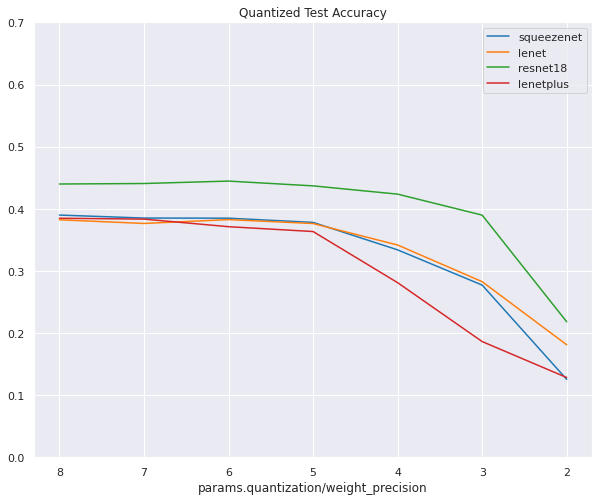

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
sns.lineplot(data=df, dashes=False)
plt.title("Quantized Test Accuracy")
plt.ylim(0, 0.7)
plt.savefig('/home/k.schwienbacher/quantization-robustness/data/test-acc-weight-co-2.jpg')


In [105]:
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
runs = []


for exp in experiments:
  df_runs = mlflow.search_runs(
    experiment_ids=exp['id'],
    filter_string="tags.stage = 'eval'",
    output_format="pandas"
  )
  fp_runs = mlflow.search_runs(
    experiment_ids=exp["train_id"] if "train_id" in exp.keys() else exp['id'],
    filter_string="tags.stage = 'train'",
    output_format="pandas",
    max_results=1,
  )
  fp_runs["params.quantization/activation_precision"] = 'fp'
  fp_runs["metrics.q_test/acc"] = fp_runs["metrics.test/acc"]
  fp_runs = fp_runs.set_index("params.quantization/activation_precision")

  run = df_runs[df_runs["params.quantization/weight_precision"] == '8'].set_index("params.quantization/activation_precision")
  run = run.append(fp_runs.iloc[0])
  run.sort_index(inplace=True, ascending=False)

  run['name'] = exp['name']
  runs.append((exp['name'], run))



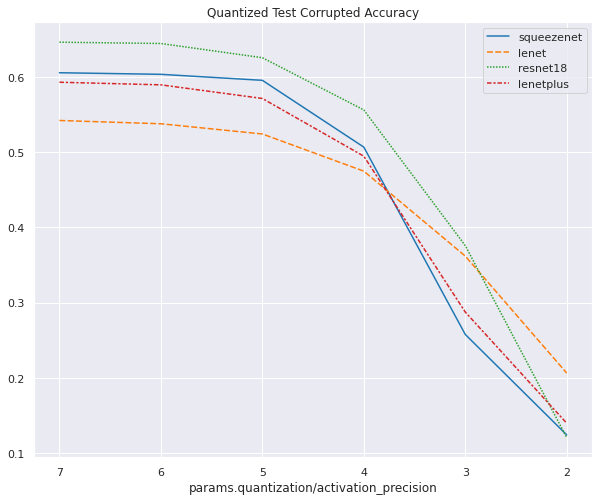

In [106]:
df = pd.DataFrame()
for name, run in runs:
    df[name] = run["metrics.q_c_test/acc"]

fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
sns.lineplot(data=df)
plt.title("Quantized Test Corrupted Accuracy")
plt.savefig('/home/k.schwienbacher/quantization-robustness/data/srl-c-act-comparison.jpg')